In [31]:
import torch
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [32]:
# create a user defined function Dataset class
# by using the "duner" or double-underscore to create methods we are creating special methods in Python that
#     python recognizes to call them automaticaly in response to built-in operations, rather than invoking them explicityly ourselves
class Joint_UDF_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    # returns the corresponding sample to the given index
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [33]:
images = pathlib.Path('/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images')

# grab all file paths
image_files = sorted([str(path) for path in images.glob('*_*.*')])

# verify files
print(f"number of images: {len(image_files)} \nfirst 10:\n{image_files[:10]}")

number of images: 50 
first 10:
['/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/0_1.jpg', '/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/10_1.webp', '/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/11_0.webp', '/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/12_0.webp', '/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/13_0.webp', '/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/14_0.jpg', '/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/15_1.jpg', '/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/16_0.jpg', '/Users/benanderson/School/F

Image shape:  (1195, 2717, 3)
Image shape:  (1020, 765, 3)
Image shape:  (1020, 765, 3)
Image shape:  (1020, 765, 3)
Image shape:  (1020, 765, 3)
Image shape:  (1020, 765, 3)


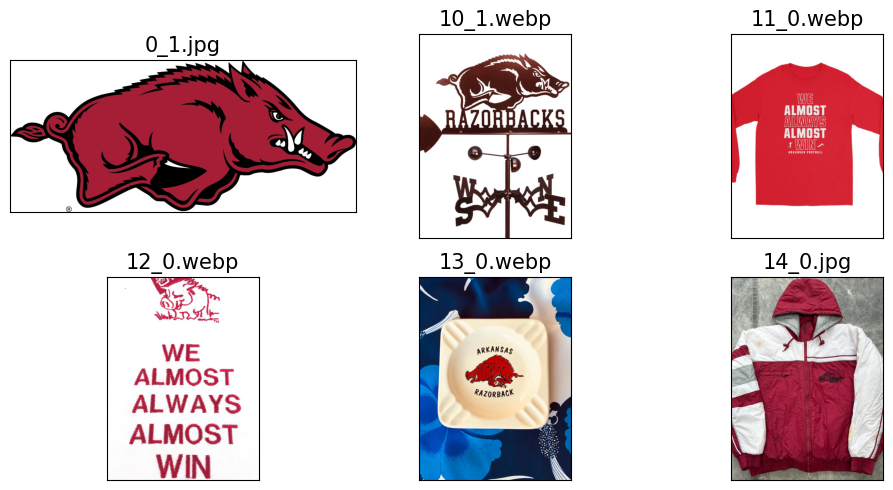

In [34]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(image_files[:6]):  # Only show first 6 images to fit 2x3 grid
    img = Image.open(file) 
    print('Image shape: ', np.array(img).shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)

plt.tight_layout()
plt.show()

In [35]:
# pull labels from file names and create label scheme
labels = [1 if '_1' in os.path.basename(file) else 0 # 1 if uses official logo
          for file in image_files]
print(f"labels: {labels}")

joint_UDF_dataset = Joint_UDF_Dataset(image_files, labels)

# print first 10
count = 1
while count <= 10:
    print(' x: ', joint_UDF_dataset[0], ' y: ', joint_UDF_dataset[1])
    count += 1

labels: [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]
 x:  ('/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/0_1.jpg', 1)  y:  ('/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/10_1.webp', 1)
 x:  ('/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/0_1.jpg', 1)  y:  ('/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/10_1.webp', 1)
 x:  ('/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/0_1.jpg', 1)  y:  ('/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/projects/project_3/data/images/10_1.webp', 1)
 x:  ('/Users/benanderson/School/Fall25/MachineLearning/DASC41103_projects_team2/proj

In [36]:
# set a standard aspect ratio for all images (# of pixels by # of pixels) to resize to
img_height, img_width = 80, 120

# defines a transform pipeline using trochvision.transforms.Compose
# compose allows chaining multiple transformations toether
# when an image is passed to the transform object, the transformation in Compose is executed in the order provided in the list
#      .ToTensor() converts a PIL image or Numpy ndarray to a Tensor
#           image becomes a torch.FloatTensor that scales original pixel value [o, 255] to [0, 1] scale and rearranges dimensions from (H, W, C) to PyTorch standard (C, H, W)
#      .Resize() resizes image to the specified dimensions to ensure a consistent size which is often requirement for deep learning models (makes it easier)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width)),
])

# update our user defined function class for joining to include transformation
# gets the transformed pixel information and join with response label instead of combining file name/path with response variable
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label
    def __len__(self):
        return len(self.labels)

# initialize perform join with data
image_dataset = ImageDataset(image_files, labels, transform)

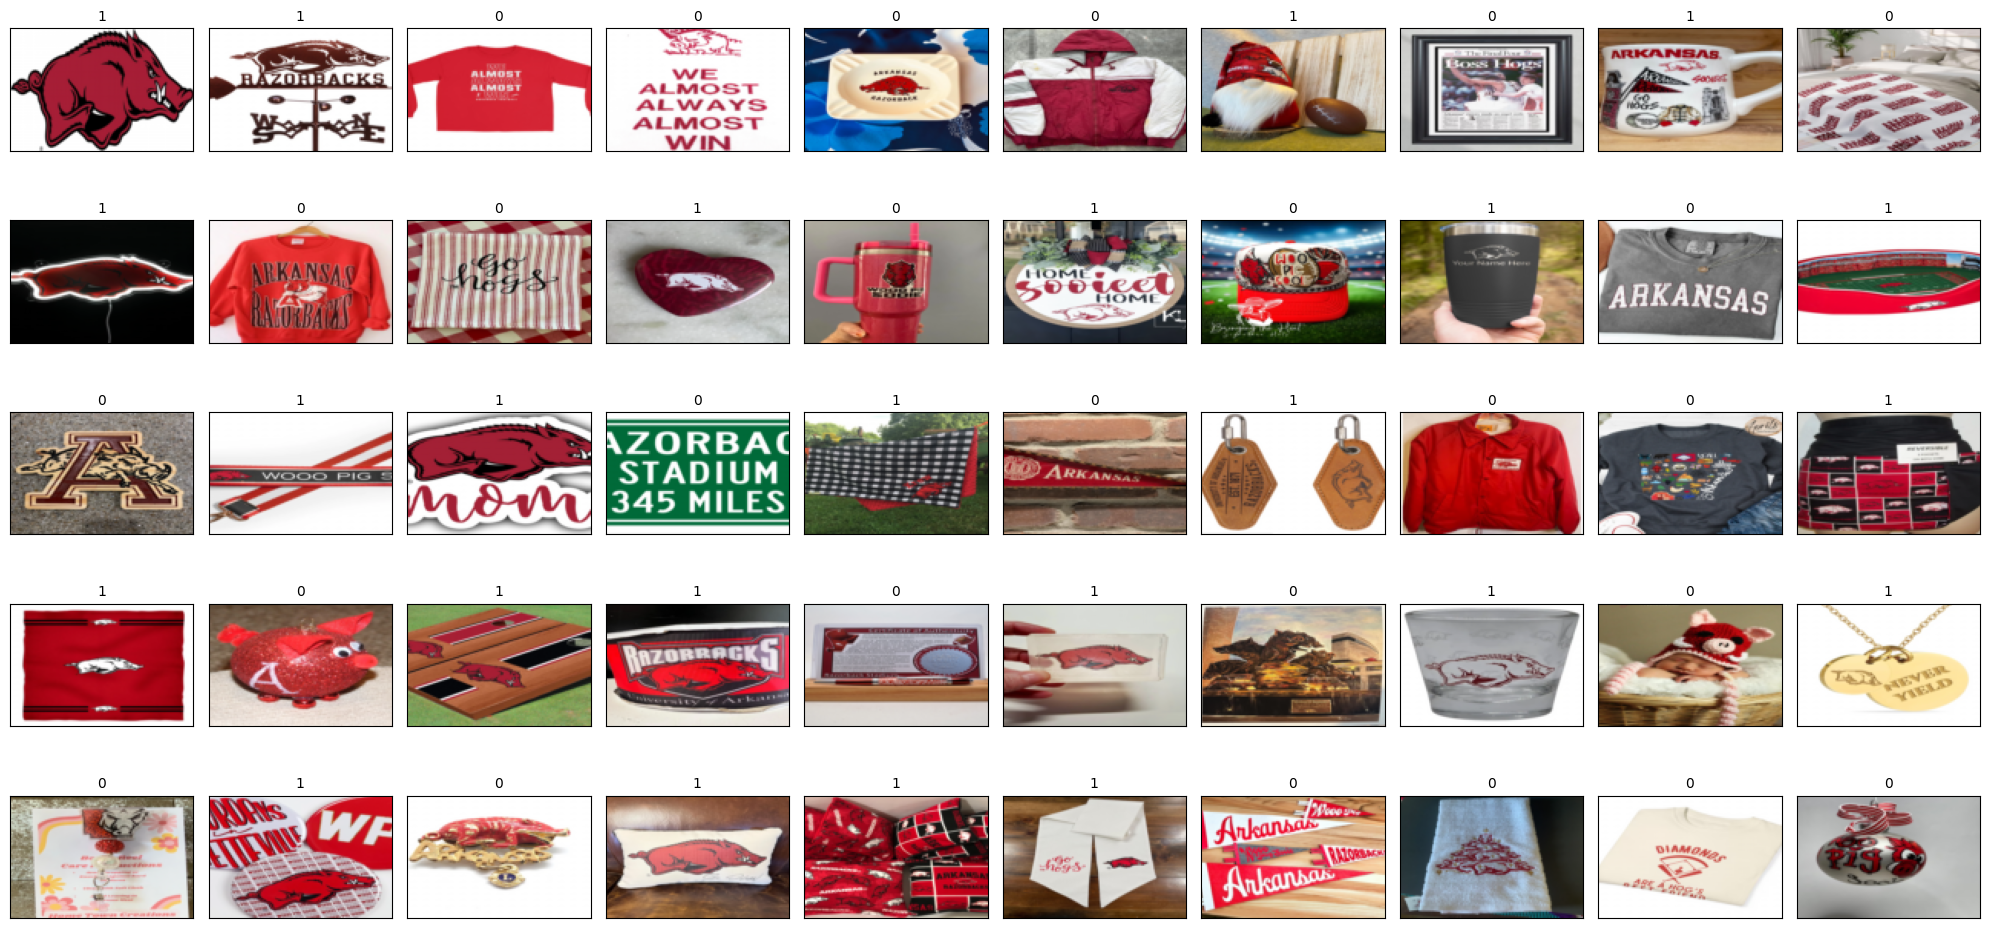

In [38]:
# print first 50 images from the dataset using pixels instead of opening each file
num_images = 50
num_cols = 10
num_rows = 5

fig = plt.figure(figsize=(20, 10))
for i, example in enumerate(image_dataset):
    if i >= num_images:
        break
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Clamp the tensor values to the range [0, 1] before displaying
    img_display = torch.clamp(example[0], 0, 1)

    ax.imshow(img_display.numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=10)

plt.tight_layout()
plt.show()